### Машинное Обучения

## Домашнее задание №2 - Дерево решений

**Общая информация**

**Срок сдачи:** 1 февраля 2023, 08:30   
**Штраф за опоздание:** -2 балла за каждые 2 дня опоздания

Решений залить в свой github репозиторий.

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс MyDecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict . (Но название класса не менять)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [2]:
def gini(y):
    # считаем число классов
    labels, counts = np.unique(y, return_counts=True)
    # превращаем в доли (вероятности)
    p = counts / len(y)
    # возвращаем критерий Джини
    if len(y) == 0:
        print(f"AYO {p} = {counts} / {len(y)}")
    return 1 - np.inner(p, p)

def entropy(y):
    # считаем число классов
    labels, counts = np.unique(y, return_counts=True)
    # превращаем в доли (вероятности)
    p = counts / len(y)
    # возвращаем энтропию
    return -np.sum(p * np.log(p))

def misclassification_error(y):
    # считаем число классов
    labels, counts = np.unique(y, return_counts=True)
    # ищем долю самого популярного класса
    p = max(counts) / len(y)
    # возвращаем 
    return 1 - p

In [3]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini', threshold_optimised = False):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        loss_func = {
            'gini': gini,
            'entropy': entropy,
            'misclassification_error': misclassification_error
        }
        self.criterion = loss_func[criterion]
        self.optimised_threshold_flag = threshold_optimised
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        self.feature_importance = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
    
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        #print(threshold, np.sort(x[:, feature_id]), sep='\n')
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
        
        
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        if self.optimised_threshold_flag:
            return self.optimised_find_threshold(x, y)
        else:
            best_feature_id = None
            best_threshold = None
            data_divided = None

            max_info_gain = -1
            parent_loss = 0

            # Считаем глобальные признаки
            parent_loss = self.criterion(y)

            # Пройдемся по всем фичам
            for feature_id in range(x.shape[1]):
                if (x[:, feature_id] == x[:, feature_id][0]).all(axis=0):
                    continue
                else:
                    thresholds = np.unique(np.sort(x[:, feature_id]))[:-1]
                    divisions = [self.__div_samples(x, y, feature_id, threshold) for threshold in thresholds]

                    left = np.array([len(division[2]) * self.criterion(division[2]) for division in divisions])
                    right = np.array([len(division[3]) * self.criterion(division[3]) for division in divisions])

                    info_gain = parent_loss * y.shape[0] - left - right

                    idx = np.argmax(info_gain)

                    if info_gain[idx] > max_info_gain:
                        max_info_gain = info_gain[idx]
                        best_feature_id = feature_id
                        best_threshold = thresholds[idx]
                        data_divided = divisions[idx]
                    '''
                    # старая версия
                    prev_hreshold = None
                    # Ищем среди значений
                    for threshold in np.sort(x[:, feature_id]):
                        # Избегаем повторений
                        if threshold == prev_hreshold:
                            continue
                        else:
                            prev_hreshold = threshold
                        # Делим по текущему порогу
                        x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, threshold)
                        # проверка на адекватность деления
                        if (y_left.shape[0] > 0) and (y_right.shape[0] > 0):
                            # прирост информативности 
                            info_gain = parent_loss * y.shape[0] - y_left.shape[0] * self.criterion(y_left) -\
                                        y_right.shape[0] * self.criterion(y_right)
                            # если он лучше прежнего, сохраняем
                            if info_gain > max_info_gain:
                                max_info_gain = info_gain
                                best_feature_id = feature_id
                                best_threshold = threshold
                                data_divided = (x_left, x_right, y_left, y_right)
                            '''

            # Сохраняем информацию о фиче
            if best_feature_id in self.feature_importance:
                self.feature_importance[best_feature_id] += max_info_gain
            else:
                self.feature_importance[best_feature_id] = max_info_gain
            # Вывели лучший признак и порог
            return best_feature_id, best_threshold, data_divided
        
        
    def optimised_find_threshold(self, x, y):
        """
        Попытка оптимизировать без двойного цикла
        """
        
        best_feature_id = None
        best_threshold = None
        data_divided = None
        
        max_info_gain = -1
        parent_loss = 0
        
        parent_loss = self.criterion(y)
        
        # Проверим наличие константных значений
        drop_feature = (x == x[0, :]).all(axis=0)
        #info_gain = parent_loss - (y_left.shape[0] * gini(y_left) + y_right.shape[0] * gini(y_right)) / y.shape[0]
        # отсортируем все колонки
        sort_idx = np.argsort(x, axis=0)
        # сделаем матрицу из лейблов
        y_matrix = np.repeat(y, x.shape[1], 0).reshape(x.shape)
        # расставим значения в соответствии с сортировкой
        x_sorted = np.take_along_axis(x, sort_idx, axis=0)
        y_sorted = np.take_along_axis(y_matrix, sort_idx, axis=0)
        
        # идем так, чтобы деление соответствовало мин. требованиям
        # Если тривиальный случай
        if x.shape[0] == 2:
            idx = 1
            
            right = y_sorted[:idx]
            left = y_sorted[idx:]
            
            info_gain = parent_loss * y_sorted.shape[0] - np.apply_along_axis(self.criterion, 0, left) * left.shape[0] - np.apply_along_axis(self.criterion, 0, right) * right.shape[0]

            # Занулим для константных признаков
            info_gain[drop_feature] = -1

            # какой признак при заданном разбиении лучший
            feature_id = np.argmax(info_gain)
            if info_gain[feature_id] > max_info_gain:
                max_info_gain = info_gain[feature_id]
                best_feature_id = feature_id
                best_threshold = x_sorted[idx - 1][best_feature_id]
        else:
            for idx in range(self.min_samples_split - 1, x.shape[0] - self.min_samples_split + 1):
                
                right = y_sorted[:idx]
                left = y_sorted[idx:]

                info_gain = parent_loss * y_sorted.shape[0] - np.apply_along_axis(self.criterion, 0, left) * left.shape[0] - np.apply_along_axis(self.criterion, 0, right) * right.shape[0]

                # Занулим для константных признаков
                info_gain[drop_feature] = -1
                
                # какой признак при заданном разбиении лучший
                feature_id = np.argmax(info_gain)
                if info_gain[feature_id] > max_info_gain:
                    max_info_gain = info_gain[feature_id]
                    best_feature_id = feature_id
                    best_threshold = x_sorted[idx - 1][best_feature_id]
            
        # Вывели лучший признак и порог
        data_divided = self.__div_samples(x, y, best_feature_id, best_threshold)
        
        return best_feature_id, best_threshold, data_divided
        
    
    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # Ваш код здесь
        NON_LEAF_TYPE = 0
        LEAF_TYPE = 1
        
        if (x.shape[0] == 0):
            raise Exception("Empty data array provided to leaf")
        
        if (x.shape[0] < self.min_samples_split) or (depth >= self.max_depth):
            # узел терминальный, нужно выдать предсказание
            # считаем число классов
            labels, counts = np.unique(y, return_counts=True)
            # ищем наиболее вероятный класс
            predict_idx = np.argmax(counts)
            # ищем вероятность
            probability = counts[predict_idx] / len(y)
            # фиксируем информацию
            self.tree[node_id] = (LEAF_TYPE, labels[predict_idx], probability)
            
        else:
            # Ищем оптимальный порог
            feature_id, threshold, data = self.__find_threshold(x, y)
            # Запоминаем деление данных
            x_left, x_right, y_left, y_right = data
            # Фиксируем текущий узел
            self.tree[node_id] = (NON_LEAF_TYPE, feature_id, threshold)
            # Идем сплитить дальше
            self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
            self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        # Ваш код здесь
        return self.feature_importance

In [4]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [5]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test), accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

(0.8888888888888888, 0.7777777777777778)

Совет: Проверьте, что ваша реализация корректно работает с признаками в которых встречаются повторы. 
И подумайте, какие еще граничные случаи могут быть.
Например, проверьте, что на таком примере ваша модель корректно работает:

In [8]:
X = np.array([[1] * 10, [0, 1, 2, 5, 6, 3, 4, 7, 8, 9]]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
for depth in range(1, 5):
    my_clf = MyDecisionTreeClassifier(max_depth=depth)
    my_clf.fit(X, y)
    print("DEPTH:", depth, "\n\t\tTree:", my_clf.tree, my_clf.predict(X))

DEPTH: 1 
		Tree: {0: (0, 1, 2), 1: (1, 1, 0.7142857142857143), 2: (1, 0, 1.0)} [0 0 0 1 1 1 1 1 1 1]
DEPTH: 2 
		Tree: {0: (0, 1, 2), 1: (0, 1, 6), 3: (1, 1, 1.0), 4: (1, 0, 0.5), 2: (0, 1, 0), 5: (1, 0, 1.0), 6: (1, 0, 1.0)} [0 0 0 0 0 0 0 1 1 1]
DEPTH: 3 
		Tree: {0: (0, 1, 2), 1: (0, 1, 6), 3: (0, 1, 7), 7: (1, 1, 1.0), 8: (1, 1, 1.0), 4: (0, 1, 4), 9: (1, 0, 1.0), 10: (1, 1, 1.0), 2: (0, 1, 0), 5: (0, 1, 1), 11: (1, 0, 1.0), 12: (1, 0, 1.0), 6: (1, 0, 1.0)} [0 0 0 0 0 1 1 1 1 1]
DEPTH: 4 
		Tree: {0: (0, 1, 2), 1: (0, 1, 6), 3: (0, 1, 7), 7: (0, 1, 8), 15: (1, 1, 1.0), 16: (1, 1, 1.0), 8: (1, 1, 1.0), 4: (0, 1, 4), 9: (0, 1, 5), 19: (1, 0, 1.0), 20: (1, 0, 1.0), 10: (0, 1, 3), 21: (1, 1, 1.0), 22: (1, 1, 1.0), 2: (0, 1, 0), 5: (0, 1, 1), 11: (1, 0, 1.0), 12: (1, 0, 1.0), 6: (1, 0, 1.0)} [0 0 0 0 0 1 1 1 1 1]


### Придумайте интересные примеры для отладки дерева решений (доп. задание)
Это необязательный пункт. За него можно получить 1 доп балл. 
Можете придумать примеры для отладки дерева, похожие на пример выше. 

Они должны быть не сложные, но в то же время информативные, чтобы можно было понять, что реализация содержит ошибки.
Вместе с примером нужно указать ожидаемый выход модели. 

In [9]:
# Примеры

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [10]:
%time clf.fit(X_train, y_train)

CPU times: user 2.38 ms, sys: 774 µs, total: 3.15 ms
Wall time: 2.61 ms


DecisionTreeClassifier()

In [11]:
%time my_clf.fit(X_train, y_train)

CPU times: user 397 ms, sys: 0 ns, total: 397 ms
Wall time: 397 ms


# От циклов к векторам
Ясно, что циклы замедляют весь процесс и я решил опробовать идею:
Для поиска порога мы сделаем следующее:
1. Мысленно разобьем батч данных на колонны и каждую такую колонуу независимо отсортируем через argsort
2. Массив лейблов через `np.repeat` преобразуем в матрицу, где каждая колонка - это копия вектора лейблов
3. Полученные из п.1 индексы применим к массиву данных и массиву(матрице) лейблов, на выходе будет массив данных, у которого каждая колонка независимо отсортирована и массив лейблов, который соответствует каждой ячейке отсортированного массива данных

Как будет выглядеть деление данных при такой обработке? - Так как массивы являются сконкатенированными отсортированными колонками, подбор порога теперь - это хождение по индексам рядов. Ведь действительно, в самом верхнем ряду находятся минимальные значения данных для каждого признака, а значит при `idx=0` мы имеем самые минимальные пороги, которые по сути делят данные на верхния ряд + оставшаяся матрица.

Остается пройтись по рядам полученной матрицы лейблов, деля ее на "верх" и "низ" и считая метрику на каждом шаге. Сам подсчет метрики выдаст нам вектор из информационных приростов по каждому признаку при заданном разбиении, остается лишь выбрать ячейку с максимальным приростом, ее индекс это и есть `feature_id`. Соответствующий можно найти как `x[idx][feature_id]`

## На словах ты Лев Толстой, а на деле?

А на деле я так (((наоптимизировал))), что мой метод `optimised_find_threshold` прироста не дал...
По этому поводу я модифицировал оригинальный метод :3
Почему так вышло? - загадка
Код:
```python
def optimised_find_threshold(self, x, y):
        """
        Попытка оптимизировать без двойного цикла
        """
        
        best_feature_id = None
        best_threshold = None
        data_divided = None
        
        max_info_gain = -1
        parent_loss = 0
        
        parent_loss = self.criterion(y)
        
        # Проверим наличие константных значений
        drop_feature = (x == x[0, :]).all(axis=0)
        #info_gain = parent_loss - (y_left.shape[0] * gini(y_left) + y_right.shape[0] * gini(y_right)) / y.shape[0]
        # отсортируем все колонки
        sort_idx = np.argsort(x, axis=0)
        # сделаем матрицу из лейблов
        y_matrix = np.repeat(y, x.shape[1], 0).reshape(x.shape)
        # расставим значения в соответствии с сортировкой
        x_sorted = np.take_along_axis(x, sort_idx, axis=0)
        y_sorted = np.take_along_axis(y_matrix, sort_idx, axis=0)
        
        # идем так, чтобы деление соответствовало мин. требованиям
        # Если тривиальный случай
        if x.shape[0] == 2:
            idx = 1
            
            right = y_sorted[:idx]
            left = y_sorted[idx:]
            
            info_gain = parent_loss * y_sorted.shape[0] - 
            np.apply_along_axis(self.criterion, 0, left) * left.shape[0] - 
            np.apply_along_axis(self.criterion, 0, right) * right.shape[0]

            # Занулим для константных признаков
            info_gain[drop_feature] = -1

            # какой признак при заданном разбиении лучший
            feature_id = np.argmax(info_gain)
            if info_gain[feature_id] > max_info_gain:
                max_info_gain = info_gain[feature_id]
                best_feature_id = feature_id
                best_threshold = x_sorted[idx - 1][best_feature_id]
        else:
            for idx in range(self.min_samples_split - 1, x.shape[0] - self.min_samples_split + 1):
                
                right = y_sorted[:idx]
                left = y_sorted[idx:]

                info_gain = parent_loss * y_sorted.shape[0] - 
                np.apply_along_axis(self.criterion, 0, left) * left.shape[0] - 
                np.apply_along_axis(self.criterion, 0, right) * right.shape[0]

                # Занулим для константных признаков
                info_gain[drop_feature] = -1
                
                # какой признак при заданном разбиении лучший
                feature_id = np.argmax(info_gain)
                if info_gain[feature_id] > max_info_gain:
                    max_info_gain = info_gain[feature_id]
                    best_feature_id = feature_id
                    best_threshold = x_sorted[idx - 1][best_feature_id]
            
        # Вывели лучший признак и порог
        data_divided = self.__div_samples(x, y, best_feature_id, best_threshold)
        
        return best_feature_id, best_threshold, data_divided        
```

In [12]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, threshold_optimised=True)

In [13]:
%time my_clf.fit(X_train, y_train)

CPU times: user 664 ms, sys: 1.74 ms, total: 666 ms
Wall time: 666 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Данные и описания колонок во вложениях.

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Либо воспользоваться функцией:

In [14]:
def preprocess_spd_data(df):
    df = df.iloc[:, :97]
    
    to_drop = [
        'id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner', 
        'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
        'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
        'field', 'undergra', 'from', 'zipcode', 'income', 'career', 'sports', 'tvsports', 'exercise', 
        'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 
        'concerts', 'music', 'shopping', 'yoga', 'expnum',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
    
    # attr1 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 
                                            'amb1_1', 'shar1_1']].sum(axis=1)
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    
    # attr2 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 
                                            'amb2_1', 'shar2_1']].sum(axis=1)
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    df = df.drop(['temp_totalsum'], axis=1)
    
    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
                'intel{}_1'.format(i), 'fun{}_1'.format(i), 
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]

        if i != 4:
            feat.remove('shar{}_1'.format(i))
    
        df = df.drop(feat, axis=1)
    
    df = df.drop(['wave'], axis=1)
    df = df.dropna()
    return df

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. В качестве метрики можно взять roc-auc. 


In [15]:
data = preprocess_spd_data(pd.read_csv('/kaggle/input/speed-dating-experiment/Speed Dating Data.csv', encoding='ISO-8859-1'))
data.head()

,iid,gender,pid,match,int_corr,samerace,age,field_cd,race,imprace,...,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1
0,1,0,11.0,0,0.14,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
1,1,0,12.0,0,0.54,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
2,1,0,13.0,1,0.16,1,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
3,1,0,14.0,1,0.61,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
4,1,0,15.0,1,0.21,0,21.0,1.0,4.0,2.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0


In [16]:
# Что с балансом?
np.unique(data.match, return_counts=True)

(array([0, 1]), array([6775, 1329]))

Так как классы несбалансированы, надо применять методы типа oversampling, undersampling и новый SMOTE - Synthetic Minority Oversampling Technique
Так как у нас тут русское поле экспериментов, а я о SMOTE слышу впервые, я выбрал его

In [17]:
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 533.0 kB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.1.0 requires joblib~=1.0.1, but you have joblib 1.2.0 which is incompatible.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.2 which is incompatible.


In [18]:
y = data['match'].to_numpy()
X = data.drop('match', axis = 1).to_numpy()

X.shape, y.shape

((8104, 32), (8104,))

In [19]:
# Undersampling - не подходит, так как идет недообучение
'''
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_reduced, y_reduced = rus.fit_resample(X, y)

print(X_reduced.shape, y_reduced.shape)

np.unique(y_reduced, return_counts=True)
'''

'\nfrom imblearn.under_sampling import RandomUnderSampler\n\nrus = RandomUnderSampler(random_state=0)\nX_reduced, y_reduced = rus.fit_resample(X, y)\n\nprint(X_reduced.shape, y_reduced.shape)\n\nnp.unique(y_reduced, return_counts=True)\n'

In [20]:
# SMOTE - наш вариант
from imblearn.over_sampling import SMOTE


sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

print(X_resampled.shape, y_resampled.shape)

# Теперь баланс
np.unique(y_resampled, return_counts=True)

(13550, 32) (13550,)


(array([0, 1]), array([6775, 6775]))

In [21]:
test_size = 0.4
X_processed, y_processed = X_resampled, y_resampled
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=test_size, stratify=y_processed)

In [22]:
X_train.shape, X_test.shape

((8130, 32), (5420, 32))

In [23]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
my_clf.fit(X_train, y_train)

In [24]:
y_pred=my_clf.predict(X_test)
accuracy_score(y_true=y_test, y_pred=y_pred)

0.694280442804428

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации и трейне от глубины дерева, от минимального числа объектов для сплита. (Т.е должно быть 2 графика, на каждой должны быть 2 кривые - для трейна и валидации)
Какой максимальной точности удалось достигнуть?

Известным фактом является то, что деревья решений сильно переобучаются при увеличении глубины и просто запоминают трейн. 
Замечаете ли вы такой эффект судя по графикам? Что при этом происходит с качеством на валидации? 

In [25]:
roc_auc_score(y_true=y_test, y_score=y_pred)

0.6942804428044281

In [26]:
clf_2 = MyDecisionTreeClassifier(min_samples_split=2, criterion='entropy')
clf_2.fit(X_train, y_train)

In [27]:
clf_3 = MyDecisionTreeClassifier(min_samples_split=2, criterion='misclassification_error')
clf_3.fit(X_train, y_train)

In [28]:
y_pred_2 = clf_2.predict(X_test)
accuracy_score(y_true=y_test, y_pred=y_pred_2), roc_auc_score(y_true=y_test, y_score=y_pred_2)

(0.6874538745387454, 0.6874538745387454)

In [29]:
y_pred_3 = clf_3.predict(X_test)
accuracy_score(y_true=y_test, y_pred=y_pred_3), roc_auc_score(y_true=y_test, y_score=y_pred_3)

(0.7033210332103321, 0.7033210332103321)

Джини дал лучший результат

## Зависимости от глубины

In [30]:
train_accuracy = []
test_accuracy = []

train_roc = []
test_roc = []

depths = [1, 2, 3, 4, 5, 7]

for depth in tqdm(depths):
    my_clf = MyDecisionTreeClassifier(max_depth=depth, criterion='gini')
    
    y_pred_train = my_clf.fit_predict(X_train, y_train, X_train)
    y_pred_test = my_clf.predict(X_test)
    
    train_accuracy.append(accuracy_score(y_true=y_train, y_pred=y_pred_train))
    test_accuracy.append(accuracy_score(y_true=y_test, y_pred=y_pred_test))
    
    train_roc.append(roc_auc_score(y_true=y_train, y_score=y_pred_train))
    test_roc.append(roc_auc_score(y_true=y_test, y_score=y_pred_test))

100%|██████████| 6/6 [07:00<00:00, 70.05s/it]


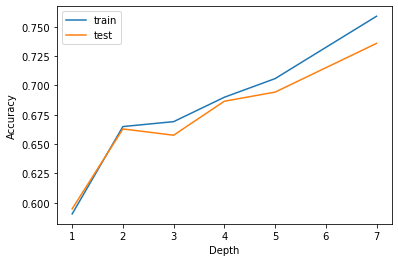

In [31]:
plt.plot(depths, train_accuracy, label='train')
plt.plot(depths, test_accuracy, label='test')

plt.xlabel('Depth')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

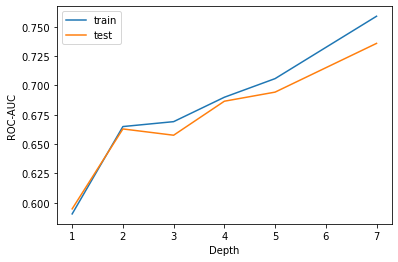

In [32]:
plt.plot(depths, train_roc, label='train')
plt.plot(depths, test_roc, label='test')

plt.xlabel('Depth')
plt.ylabel('ROC-AUC')

plt.legend()
plt.show()

## Зависимости от минимального сплита

In [33]:
train_accuracy = []
test_accuracy = []

train_roc = []
test_roc = []

min_splits = [2 ** i for i in range(1, 5)]

for min_split in tqdm(min_splits):
    my_clf = MyDecisionTreeClassifier(max_depth=15, min_samples_split=min_split, criterion='gini')
    
    y_pred_train = my_clf.fit_predict(X_train, y_train, X_train)
    y_pred_test = my_clf.predict(X_test)
    
    train_accuracy.append(accuracy_score(y_true=y_train, y_pred=y_pred_train))
    test_accuracy.append(accuracy_score(y_true=y_test, y_pred=y_pred_test))
    
    train_roc.append(roc_auc_score(y_true=y_train, y_score=y_pred_train))
    test_roc.append(roc_auc_score(y_true=y_test, y_score=y_pred_test))

100%|██████████| 4/4 [10:12<00:00, 153.18s/it]


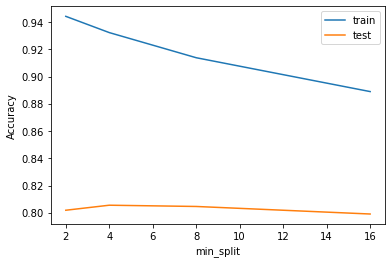

In [34]:
plt.plot(min_splits, train_accuracy, label='train')
plt.plot(min_splits, test_accuracy, label='test')

plt.xlabel('min_split')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

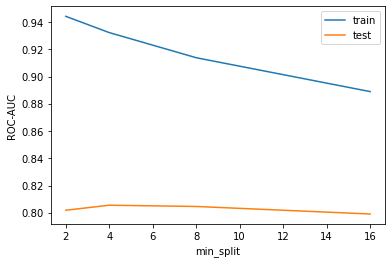

In [35]:
plt.plot(min_splits, train_roc, label='train')
plt.plot(min_splits, test_roc, label='test')

plt.xlabel('min_split')
plt.ylabel('ROC-AUC')

plt.legend()
plt.show()

Деревья действительно склонны к переобучению, это видно по разнице кривой теста и треина. Сплит лучше держать около 2ки

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [36]:
final_clf = MyDecisionTreeClassifier(criterion='gini')
final_clf.fit(X_train, y_train)

In [37]:
data.drop('match', axis = 1).columns[sorted(final_clf.get_feature_importance())][:10]

Index(['iid', 'pid', 'int_corr', 'samerace', 'age', 'race', 'goal', 'date',
       'exphappy', 'intel1_1'],
      dtype='object')

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?
То как можно ускорить дерево - неясно. Есть материал в книге ШАДа, но тамошняя идея с динамическим программированием не была понята полностью: пробовал подсчитывать частоту классов заранее, была еще идея подбирать пороги через квантили, но как-то не пошло, хотелось бы узнать как можно ускорить алгоритм

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

Неиронично, но с деревьями я познакомился по-новому, не жалею, что руками в них покопался.

### ВАШ ОТЗЫВ ЗДЕСЬ

